In [1]:
# script to make Arkane ScanLog text file for a given species or TS conformer

In [166]:
import os
import sys
import glob
import numpy as np

import ase.atoms
import ase.io.gaussian
import ase.visualize

# need this set to represent the RMG molecule and get the rotors
DFT_DIR = os.environ['DFT_DIR']
sys.path.append(DFT_DIR)
sys.path.append(os.environ['DATABASE_DIR'])
import autotst_wrapper
import autotst.reaction
import autotst.species
import database_fun

import rmgpy.constants

import xtb.ase.calculator


import arkane.ess  # just to check our answers

import matplotlib.pyplot as plt
%matplotlib inline

In [172]:
def get_linear_fit(opt_files):
    m = None
    b = None
    if type(opt_files) != list:
        opt_files = [opt_files]
    xtb_energies = []
    m06_energies = []
    for opt_file in opt_files:
        with open(opt_file, 'r') as f:
            frames = ase.io.gaussian.read_gaussian_out(f, slice(None, None))

        for j in range(len(frames)):
            if not frames[j].calc.results or 'forces' not in frames[j].calc.results.keys():
                continue

            m06_energies.append(frames[j].calc.results['energy'])
            atoms = ase.Atoms(frames[j].numbers, frames[j].positions)
            atoms.calc = xtb.ase.calculator.XTB()
            xtb_energies.append(atoms.get_potential_energy())
    if len(xtb_energies) < 2:
        print('Not enough optimization points for a linear fit!')
        return m, b

        # fit a line
    m, b = np.polyfit(xtb_energies, m06_energies, 1)
    return m, b

# Build the RMG molecule or reaction from the optimized geometry

### Species Rotors

In [164]:
# Get the rmg species
species_index = 4
rmg_species = database_fun.index2species(species_index)
species_smiles = rmg_species.smiles
conformer_dir = os.path.join(DFT_DIR, 'thermo', f'species_{species_index:04}', 'conformers')
species_file = autotst_wrapper.get_lowest_valid_conformer(conformer_dir)


2025-04-03 13:04:51.404803 Lowest energy conformer is /work/westgroup/harris.se/autoscience/reaction_calculator/dft/thermo/species_0004/conformers/conformer_0000.log


In [165]:
# make the autotst species object
autotst_cf = autotst.species.Conformer(smiles=species_smiles)
with open(species_file, 'r') as f:
    atoms = ase.io.gaussian.read_gaussian_out(f)
    assert not autotst_wrapper.bonds_too_large(None, species_index, atoms=atoms)
    
autotst_cf._ase_molecule = atoms
autotst_cf.update_coords_from(mol_type="ase")
torsions = autotst_cf.get_torsions()
n_rotors = len(torsions)

In [173]:
species_files = glob.glob(os.path.join(DFT_DIR, 'thermo', f'species_{species_index:04}', '*', '*.log'))
m, b = get_linear_fit(species_files)

In [174]:
rotor_energies = []
for rotor_index in range(n_rotors):
    atoms = autotst_cf.get_ase_mol()
#     angles = np.linspace(0, 360, 73)  # every 5 degrees
    angles = np.linspace(0, 360, 21)  # every 5 degrees
    energies = np.zeros(len(angles))

    starting_dihedral = atoms.get_dihedral(
        autotst_cf.torsions[rotor_index].atom_indices[0],
        autotst_cf.torsions[rotor_index].atom_indices[1],
        autotst_cf.torsions[rotor_index].atom_indices[2],
        autotst_cf.torsions[rotor_index].atom_indices[3],
    )

    for angle_index in range(len(angles)):
        # Reset dihedral to optimized starting point
        atoms.set_dihedral(
            autotst_cf.torsions[rotor_index].atom_indices[0],
            autotst_cf.torsions[rotor_index].atom_indices[1],
            autotst_cf.torsions[rotor_index].atom_indices[2],
            autotst_cf.torsions[rotor_index].atom_indices[3],
            starting_dihedral,
            mask=autotst_cf.torsions[rotor_index].mask
        )

        # and rotate to desired increment
        atoms.rotate_dihedral(
            autotst_cf.torsions[rotor_index].atom_indices[0],
            autotst_cf.torsions[rotor_index].atom_indices[1],
            autotst_cf.torsions[rotor_index].atom_indices[2],
            autotst_cf.torsions[rotor_index].atom_indices[3],
            angles[angle_index],
            mask=autotst_cf.torsions[rotor_index].mask
        )
        atoms.calc = xtb.ase.calculator.XTB()
        energies[angle_index] = m * atoms.get_potential_energy() + b
    rotor_energies.append(energies)

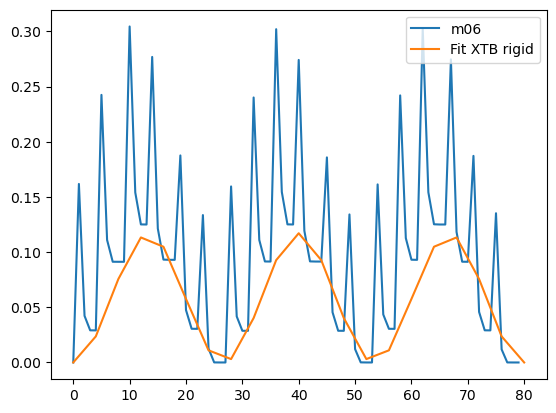

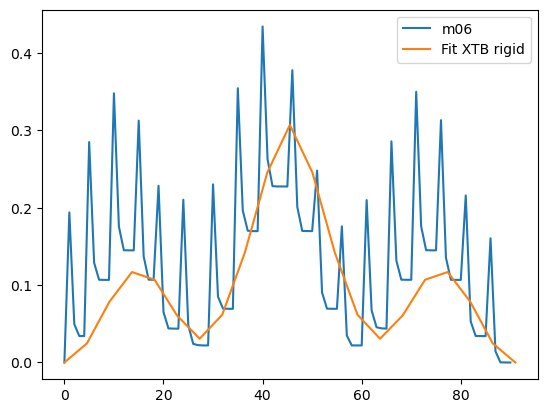

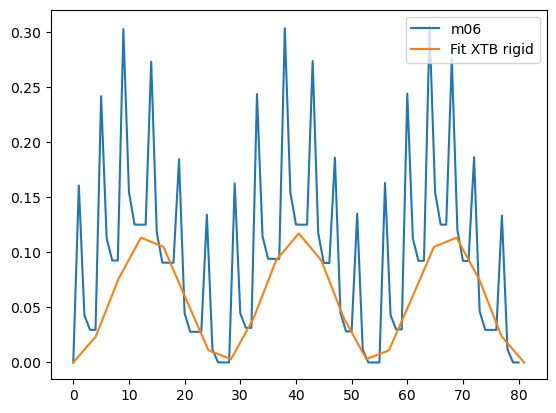

In [175]:
# Grab the actual rotor calcs for comparison (these are relaxed so it's not apples to apples)

for rotor_index in range(len(rotor_energies)):
    actual_rotor_file = os.path.join(DFT_DIR, 'thermo', f'species_{species_index:04}', 'rotors', f'rotor_{rotor_index:04}.log')
    
    with open(actual_rotor_file, 'r') as f:
        frames = ase.io.gaussian.read_gaussian_out(f, slice(None, None))
        
        frames = [atoms for atoms in frames if atoms.calc.results]
        
        m06_energies = np.array([atoms.calc.results['energy'] for atoms in frames])
        plt.plot(m06_energies - np.min(m06_energies), label='m06')
        ax = plt.gca()
        
        
        xs = np.linspace(0, len(frames), len(rotor_energies[rotor_index]))
#         plt.show()
        ax.yaxis.get_major_formatter().set_useOffset(False)
        plt.plot(xs, rotor_energies[rotor_index] - np.min(rotor_energies[rotor_index]), label='Fit XTB rigid')
        plt.legend()
        plt.show()

In [176]:
def load_scan_energies(rotor_log):
    """
    Extract the optimized energies in J/mol from a log file, e.g. the 
    result of a Gaussian "Scan" quantum chemistry calculation.
    """
    opt_freq = False
    rigid_scan = False

    vlist = []  # The array of potentials at each scan angle
    non_optimized = []  # The array of indexes of non-optimized point

    internal_coord = 'D(' + ','.join(rotor_log.load_scan_pivot_atoms()) + ')'
    angle = []
    # Parse the Gaussian log file, extracting the energies of each
    # optimized conformer in the scan
    with open(rotor_log.path, 'r') as f:
        line = f.readline()
        while line != '':
            # If the job contains a "freq" then we want to ignore the last energy
            if ' Freq' in line and ' Geom=' in line:
                opt_freq = True
            # if # scan is keyword instead of # opt, then this is a rigid scan job
            # and parsing the energies is done a little differently
            if '# scan' in line:
                rigid_scan = True
            # The lines containing "SCF Done" give the energy at each
            # iteration (even the intermediate ones)
            if 'SCF Done:' in line:
                energy = float(line.split()[4])
                # rigid scans will only not optimize, so just append every time it finds an energy.
                if rigid_scan:
                    vlist.append(energy)
            # We want to keep the values of energy that come most recently before
            # the line containing "Optimization completed", since it refers
            # to the optimized geometry
            if 'Optimization completed' in line:
                vlist.append(energy)
            # In some cases, the optimization cannot converge within the given steps.
            # Then, the geometry is not optimized. we need to exclude these values.
            if 'Optimization stopped' in line:
                non_optimized.append(len(vlist))
                vlist.append(energy)
            # Read the optimized angle from optimized parameters
            if internal_coord in line and 'Scan' not in line:
                # EXAMPLE:
                # ! D9    D(1,2,3,15)            42.4441         -DE/DX =    0.0                 !
                angle.append(float(line.strip().split()[3]))

            line = f.readline()
    return vlist, angle

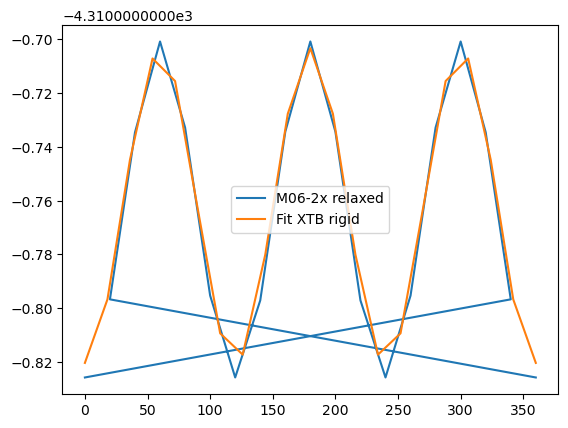

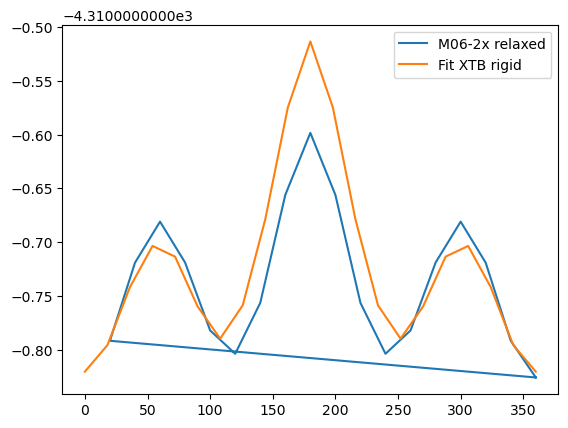

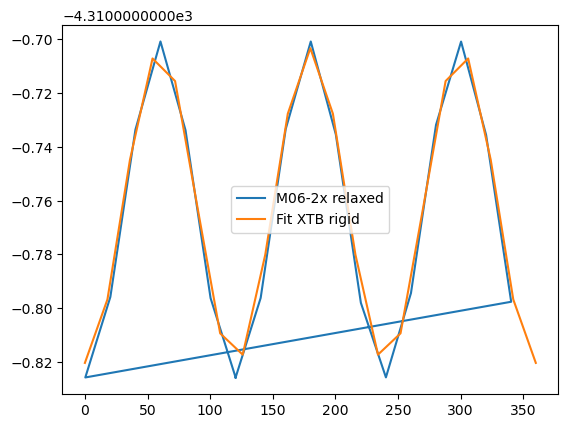

In [177]:
# Grab the actual rotor calcs for comparison (these are relaxed so it's not apples to apples)
for rotor_index in range(len(rotor_energies)):
    actual_rotor_file = os.path.join(DFT_DIR, 'thermo', f'species_{species_index:04}', 'rotors', f'rotor_{rotor_index:04}.log')
    
    rotor_log = arkane.ess.ess_factory(actual_rotor_file)
    vlist, angle = load_scan_energies(rotor_log)
    plt.plot(np.array(angle) + 180, np.array(vlist) * 27.2114, label='M06-2x relaxed')  # convert Ha to eV
    plt.plot(angles, rotor_energies[rotor_index], label='Fit XTB rigid')
    plt.legend()
    plt.show()

In [162]:
reaction_file

'/work/westgroup/harris.se/autoscience/reaction_calculator/dft/kinetics/reaction_000213/overall/fwd_ts_0000.log'

### TS Rotors

In [155]:
# Get the rmg species
reaction_index = 213
direction = 'forward'
rmg_reaction = database_fun.index2reaction(reaction_index)
reaction_smiles = database_fun.reaction_index2smiles(reaction_index)

conformer_dir = os.path.join(DFT_DIR, 'kinetics', f'reaction_{reaction_index:06}', 'overall')
reaction_file = autotst_wrapper.get_lowest_valid_ts(conformer_dir)


reaction.py:360 get_labeled_reaction INFO Trying to match reaction to <ReactionFamily "1,3_sigmatropic_rearrangement">
reaction.py:360 get_labeled_reaction INFO Trying to match reaction to <ReactionFamily "Disproportionation">
reaction.py:389 get_labeled_reaction INFO Matched reaction to Disproportionation family
reaction.py:360 get_labeled_reaction INFO Trying to match reaction to <ReactionFamily "1,3_sigmatropic_rearrangement">
reaction.py:360 get_labeled_reaction INFO Trying to match reaction to <ReactionFamily "Disproportionation">
reaction.py:389 get_labeled_reaction INFO Matched reaction to Disproportionation family
base.py:755 estimate_distances_using_group_additivity WARNING No distance data found at Root_N-4R->H_4CNOS-u1_1R!H->O_N-2R!H->C_N-4CNOS->O_4CN->C. Falling up tree node to Root_N-4R->H_4CNOS-u1_1R!H->O_N-2R!H->C_N-4CNOS->O
base.py:755 estimate_distances_using_group_additivity WARNING No distance data found at Root_N-4R->H_4CNOS-u1_1R!H->O_N-2R!H->C_N-4CNOS->O. Falling 

2025-04-03 12:55:00.516712 TS is valid
2025-04-03 12:55:00.533951 Verifying bond counts for reaction 213


base.py:755 estimate_distances_using_group_additivity WARNING No distance data found at Root_N-4R->H_4CNOS-u1_1R!H->O_N-2R!H->C_N-4CNOS->O. Falling up tree node to Root_N-4R->H_4CNOS-u1_1R!H->O_N-2R!H->C
base.py:755 estimate_distances_using_group_additivity WARNING No distance data found at Root_N-4R->H_4CNOS-u1_1R!H->O_N-2R!H->C. Falling up tree node to Root_N-4R->H_4CNOS-u1_1R!H->O
reaction.py:270 generate_distance_data INFO Distance between *1 and *3 is too small, setting it to lower bound of uncertainty
reaction.py:279 generate_distance_data INFO The distance data is as follows: DistanceData(distances={'d12': 1.493630,'d13': 2.513338,'d23': 1.057619,}, uncertainties={'d12': 0.019554,'d13': 0.006102,'d23': 0.006769,})
reaction.py:798 get_rdkit_mol INFO Initially embedded molecule
reaction.py:803 get_rdkit_mol INFO Getting bounds matrix
reaction.py:807 get_rdkit_mol INFO Editing bounds matrix
reaction.py:837 set_limits INFO For atoms 2 and 4 we have a distance of: 	 1.493629999999999

In [156]:
reaction = autotst.reaction.Reaction(label=reaction_smiles)  # going back to this even though it's not dependable
reaction.ts[direction][0]._ase_molecule = autotst_wrapper.get_gaussian_file_geometry(reaction_file)
reaction.ts[direction][0].update_coords_from(mol_type="ase")
torsions = reaction.ts[direction][0].get_torsions()
n_rotors = len(torsions)

reaction.py:360 get_labeled_reaction INFO Trying to match reaction to <ReactionFamily "1,3_sigmatropic_rearrangement">
reaction.py:360 get_labeled_reaction INFO Trying to match reaction to <ReactionFamily "Disproportionation">
reaction.py:389 get_labeled_reaction INFO Matched reaction to Disproportionation family
reaction.py:360 get_labeled_reaction INFO Trying to match reaction to <ReactionFamily "1,3_sigmatropic_rearrangement">
reaction.py:360 get_labeled_reaction INFO Trying to match reaction to <ReactionFamily "Disproportionation">
reaction.py:389 get_labeled_reaction INFO Matched reaction to Disproportionation family
base.py:755 estimate_distances_using_group_additivity WARNING No distance data found at Root_N-4R->H_4CNOS-u1_1R!H->O_N-2R!H->C_N-4CNOS->O_4CN->C. Falling up tree node to Root_N-4R->H_4CNOS-u1_1R!H->O_N-2R!H->C_N-4CNOS->O
base.py:755 estimate_distances_using_group_additivity WARNING No distance data found at Root_N-4R->H_4CNOS-u1_1R!H->O_N-2R!H->C_N-4CNOS->O. Falling 

In [178]:
reaction_files = glob.glob(os.path.join(DFT_DIR, 'kinetics', f'reaction_{reaction_index:06}', '*', '*.log'))
m, b = get_linear_fit(reaction_files)

In [179]:
autotst_cf = reaction.ts[direction][0]

In [180]:
rotor_energies = []
for rotor_index in range(n_rotors):
    atoms = autotst_cf.get_ase_mol()
#     angles = np.linspace(0, 360, 73)  # every 5 degrees
    angles = np.linspace(0, 360, 21)  # every 5 degrees
    energies = np.zeros(len(angles))

    starting_dihedral = atoms.get_dihedral(
        autotst_cf.torsions[rotor_index].atom_indices[0],
        autotst_cf.torsions[rotor_index].atom_indices[1],
        autotst_cf.torsions[rotor_index].atom_indices[2],
        autotst_cf.torsions[rotor_index].atom_indices[3],
    )

    for angle_index in range(len(angles)):
        # Reset dihedral to optimized starting point
        atoms.set_dihedral(
            autotst_cf.torsions[rotor_index].atom_indices[0],
            autotst_cf.torsions[rotor_index].atom_indices[1],
            autotst_cf.torsions[rotor_index].atom_indices[2],
            autotst_cf.torsions[rotor_index].atom_indices[3],
            starting_dihedral,
            mask=autotst_cf.torsions[rotor_index].mask
        )

        # and rotate to desired increment
        atoms.rotate_dihedral(
            autotst_cf.torsions[rotor_index].atom_indices[0],
            autotst_cf.torsions[rotor_index].atom_indices[1],
            autotst_cf.torsions[rotor_index].atom_indices[2],
            autotst_cf.torsions[rotor_index].atom_indices[3],
            angles[angle_index],
            mask=autotst_cf.torsions[rotor_index].mask
        )
        atoms.calc = xtb.ase.calculator.XTB()
        energies[angle_index] = m * atoms.get_potential_energy() + b
    rotor_energies.append(energies)

In [183]:
# # Grab the actual rotor calcs for comparison (these are relaxed so it's not apples to apples)

# for rotor_index in range(len(rotor_energies)):
#     actual_rotor_file = os.path.join(DFT_DIR, 'kinetics', f'reaction_{reaction_index:06}', 'rotors', f'rotor_{rotor_index:04}.log')
    
#     with open(actual_rotor_file, 'r') as f:
#         frames = ase.io.gaussian.read_gaussian_out(f, slice(None, None))
        
#         frames = [atoms for atoms in frames if atoms.calc.results]
        
#         m06_energies = np.array([atoms.calc.results['energy'] for atoms in frames])
#         plt.plot(m06_energies - np.min(m06_energies), label='m06')
#         ax = plt.gca()
        
        
#         xs = np.linspace(0, len(frames), len(rotor_energies[rotor_index]))
# #         plt.show()
#         ax.yaxis.get_major_formatter().set_useOffset(False)
#         plt.plot(xs, rotor_energies[rotor_index] - np.min(rotor_energies[rotor_index]), label='Fit XTB rigid')
#         plt.legend()
#         plt.show()

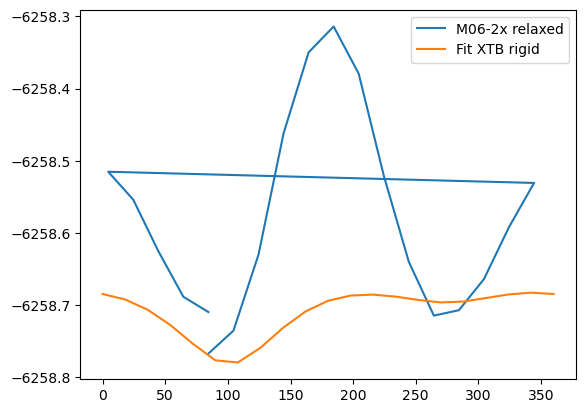

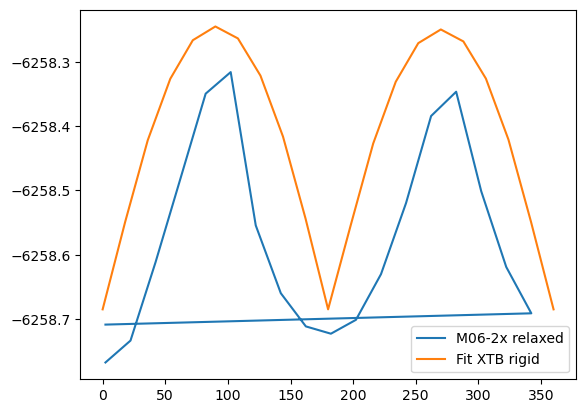

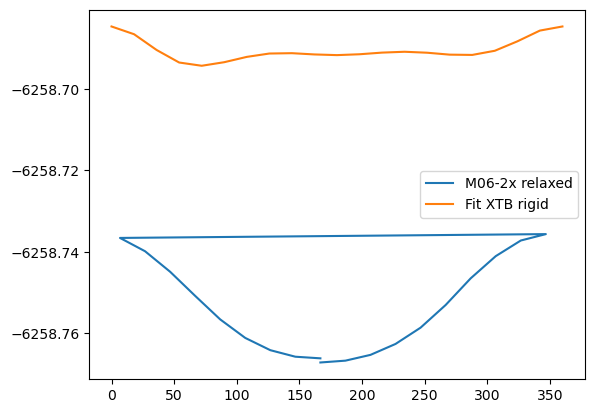

In [184]:
# Grab the actual rotor calcs for comparison (these are relaxed so it's not apples to apples)
for rotor_index in range(len(rotor_energies)):
    actual_rotor_file = os.path.join(DFT_DIR, 'kinetics', f'reaction_{reaction_index:06}', 'rotors', f'rotor_{rotor_index:04}.log')
    
    rotor_log = arkane.ess.ess_factory(actual_rotor_file)
    vlist, angle = load_scan_energies(rotor_log)
    plt.plot(np.array(angle) + 180, np.array(vlist) * 27.2114, label='M06-2x relaxed')  # convert Ha to eV
    plt.plot(angles, rotor_energies[rotor_index], label='Fit XTB rigid')
    ax = plt.gca()
    ax.yaxis.get_major_formatter().set_useOffset(False)
    plt.legend()
    plt.show()